In [5]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
from typing import Literal, Callable
from numpy import typing as npt

from smartexp import core

In [150]:
# Aca pongo cuales son realmente los tipos
# No hace falta ponerle el mismo nombre pero es comodo
from typing import Any


from numpy import floating
import scipy.stats as ss


type ShapeT = tuple[int, ...]
type Param = np.ndarray[tuple[Literal[5], ], np.dtype[np.float64]]
type Control = float
type Output = np.float64
type Data = tuple[list[Control], list[Output]]

type Model = Callable[[Control, Param], Output]

P_NATURE: Param = 1. * np.asarray([1, 2, 3, 4, 5, 6, 7, 8, 9])
DOMAIN = (-100, 100)

def _nature(control: Control) -> Output:
    """The TRUTH about the system.
    """
    return np.polynomial.Polynomial(P_NATURE, domain=DOMAIN)(control)

def _measure(control: Control) -> Output:
    """A REAL measurement (that we simulate for the time being).
    """
    NOISE_CONTROL = 0
    NOISE_MEASURE = 0

    # Sometimes the set control parameter is not properly set.
    control = np.random.normal(control, np.abs(NOISE_CONTROL * control))

    # The output of the system, given the control.
    value = _nature(control)

    # The measured values is not the output of the system
    # but the square of it.
    value = value ** 2

    # The measured values has noise.
    return np.random.normal(value, NOISE_MEASURE * np.abs(value))

def _model(control: Control, params: Param) -> Output:
    """Our model of the system
    """
    return np.polynomial.Polynomial(params, domain=DOMAIN)(control)

def _simulate_measure(control: Control, params: Param) -> Output:
    """Our model of the system and the experiment.
    """
    value = _model(control, params)
    value = value ** 2
    return value

def _update(control: Control, output: Output, data: Data) -> Data:
    data[0].append(control)
    data[1].append(output)
    return data

def _sse(params: Param, model: Model, data: Data) -> floating[Any]:
    c, o = data
    delta = model(np.asarray(c), params) - np.asarray(o)
    return np.mean(delta * delta)


def _fit(model: Model, data: Data, p0: Param) -> tuple[Param, Param] | None:
    res = optimize.minimize(_sse, x0=p0, args=(model, data, ))
    return res.x, np.ones_like(res.x)

def _suggest(model: Model, data: Data, best_params: Param, unc_params: Param) -> Control:
    return np.random.uniform(DOMAIN[0], DOMAIN[1])

def _suggest_update(model: Model, data: Data, best_params: Param, unc_params: Param) -> Control:
    f = ss.uniform(loc=DOMAIN[0], scale=DOMAIN[1] - DOMAIN[0])
    x = np.linspace(DOMAIN[0], DOMAIN[1], 10000)
    alpha = 10
    scale=5
    f = ss.uniform(loc=DOMAIN[0], scale=DOMAIN[1]-DOMAIN[0]).pdf(x)
    for loc in data[0]:
        f = f * (1 - alpha * ss.norm(loc=loc, scale=scale).pdf(x))
        f = f / np.sum(f)
    outcomes = np.arange(len(f))
    choice = np.random.choice(outcomes, size=1, p=f)[0]
    return x[choice]

class TSE(core.SmartExperiment[Data, Param, Control, Output]):

    measure = staticmethod(_measure)
    simulate_measure = staticmethod(_simulate_measure)
    update = staticmethod(_update)
    fit = staticmethod(_fit)
    suggest = staticmethod(_suggest)

    def __init__(self, p0: Param):
        self.data = ([], [])
        super().__init__(p0)

class TSE2(core.SmartExperiment[Data, Param, Control, Output]):

    measure = staticmethod(_measure)
    simulate_measure = staticmethod(_simulate_measure)
    update = staticmethod(_update)
    fit = staticmethod(_fit)
    suggest = staticmethod(_suggest_update)

    def __init__(self, p0: Param):
        self.data = ([], [])
        super().__init__(p0)



real params: [1. 2. 3. 4. 5. 6. 7. 8. 9.]
data: ([array(2.)], [1.0841657847339288])
starting params: [0.59560548 0.98962646 0.91563905 0.94157103 0.45774141 0.52042731
 0.82627651 0.07557259 0.53259455]
real params 2: [1. 2. 3. 4. 5. 6. 7. 8. 9.]
data 2: ([array(2.)], [1.0841657847339288])
starting params 2: [0.59241673 0.54890822 0.36259734 0.76697763 0.40228852 0.36961471
 0.1293113  0.90353564 0.13961008]


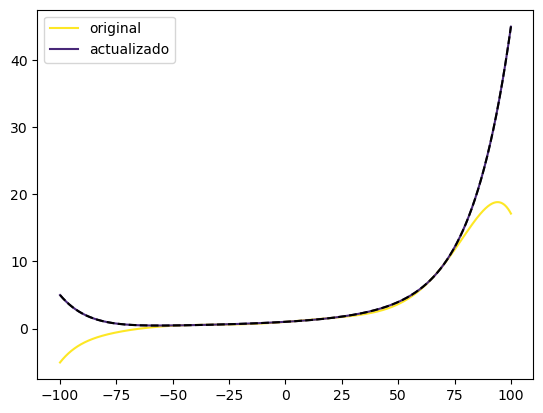

params: [  0.98778156   2.5713314    2.75529405  -8.48197948  -3.21689493
  53.30222869  44.99456124 -36.29943696 -39.48638116]


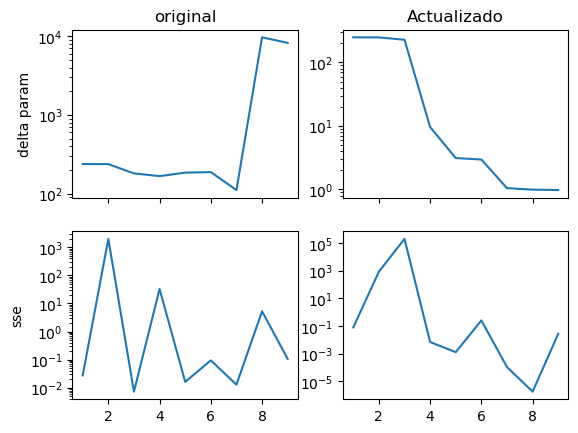

In [184]:
se = TSE(np.random.random(size=P_NATURE.shape))
se2 = TSE2(np.random.random(size=P_NATURE.shape))

se.acquire(np.asarray(2.))
se2.acquire(np.asarray(2.))
print(f"real params: {P_NATURE}")
print(f"data: {se.data}")
print(f"starting params: {se.last_best_params}")

print(f"real params 2: {P_NATURE}")
print(f"data 2: {se2.data}")
print(f"starting params 2: {se2.last_best_params}")

deltas: list[float] = []
sse: list[float] = []

deltas2: list[float] = []
sse2: list[float] = []

STEPS = np.arange(1, 10)

cmap = plt.get_cmap('viridis')
colors = cmap(STEPS/len(STEPS))
x = np.linspace(-100, 100, 10000)
for color, n in zip(colors, STEPS):
    # print(f"--- {n:03d} ---")
    se.step()
    se2.step()
    # print(f"data: {se.data}")
    # print(f"params: {se.last_best_params}")
    deltas.append(np.sum((se.last_best_params - P_NATURE)**2))
    sse.append(_sse(se.last_best_params, _simulate_measure, se.data))

    deltas2.append(np.sum((se2.last_best_params - P_NATURE)**2))
    sse2.append(_sse(se2.last_best_params, _simulate_measure, se2.data))

plt.plot(x, _model(x, se.last_best_params), color=color, label="original")
plt.plot(x, _model(x, se2.last_best_params), color=colors[0], label="actualizado")
plt.plot(x, _nature(x), linestyle="dashed", color="k")
plt.legend()
plt.show()

print(f"params: {se.last_best_params}")
fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(2, 2, sharex=True)
ax1.set_title("original")
ax1.plot(STEPS, deltas)
ax1.set_ylabel("delta param")
ax2.plot(STEPS, sse)
ax2.set_ylabel("sse")
ax1.set_yscale('log')
ax2.set_yscale('log')

ax3.set_title("Actualizado")
ax3.plot(STEPS, deltas2)
ax3.set_yscale('log')
ax4.plot(STEPS, sse2)
ax4.set_yscale('log')

plt.show()


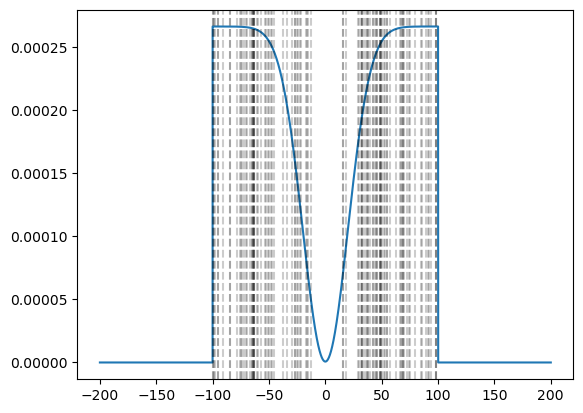

In [105]:
x = np.linspace(-200, 200, 10000)
alpha = 50
scale=20
loc=0

f = ss.uniform(loc=DOMAIN[0], scale=DOMAIN[1]-DOMAIN[0]).pdf(x) * (1 - alpha * ss.norm(loc=loc, scale=scale).pdf(x))
#f = ss.uniform(loc=DOMAIN[0], scale=DOMAIN[1]-DOMAIN[0]).pdf(x) 
f = f / np.sum(f)
outcomes = np.arange(len(f))
choices = np.random.choice(outcomes, size=100, p=f)
plt.plot(x, f)
[plt.axvline(x[choice], linestyle="dashed", color="k", alpha=0.2) for choice in choices]
plt.show()